In [1]:
import pandas as pd
import numpy as np
import pickle
import os

import keras
import tensorflow as tf
from keras.utils import plot_model 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

import data_utils as DataUtils

2024-04-11 10:19:27.111428: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-11 10:19:27.838208: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-11 10:19:27.853819: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 10:19:30.300332: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Dataframe tutorial

In [2]:
# lead data frame and class dictionary
df = DataUtils.load_data_frame()
class_dict = DataUtils.get_class_dict()

# keep class definitions for later use
print("Class dict:")
for key, value in class_dict.items():
    print(key, ":", value)

# print first n rows of data frame
n = 5
df.head(n)
features_i_want = ['One-Hot Label','Probability']
class_old_pred = df[features_i_want].values

Data path:  /home/johnm100/researchproject/Undergrad-Research/Working/data/
Class dict:
Merged : [0, 1]
Isolated : [1, 0]


In [3]:
class_old_pred 


array([[array([1., 0.], dtype=float32), 0.5979700088500977],
       [array([1., 0.], dtype=float32), 0.7392799854278564],
       [array([1., 0.], dtype=float32), 0.9986000061035156],
       ...,
       [array([0., 1.], dtype=float32), 0.021040000021457672],
       [array([0., 1.], dtype=float32), 0.021040000021457672],
       [array([0., 1.], dtype=float32), 0.9444500207901001]], dtype=object)

In [4]:
class_dict

{'Merged': [0, 1], 'Isolated': [1, 0]}

## Plotting functions

In [5]:
def convert_predictions_to_class_vector(y_pred):
    lab = np.zeros_like(y_pred)
    for i in range(len(y_pred)):
        lab[i][np.argmax(y_pred[i])] = 1
    return lab

def convert_class_vector_to_string(y_lab, class_dict):
    y_lab_str = []

    # set max value to 1 and others to 0 (for predictions)
    y_lab_normed = convert_predictions_to_class_vector(y_lab)

    for i in range(len(y_lab_normed)):
        for key, value in class_dict.items():
            if np.array_equal(y_lab_normed[i], value):
                y_lab_str.append(key)
                break
    return np.array(y_lab_str)

def state_percentages(y,class_dict):
    ''' 
     Calculates percentage of each class
    '''
    n_of_each_state = {}
    for key in class_dict.keys():
        n_of_each_state[key] = 0
    for i in range(len(y)):
        for key, value in class_dict.items():
            if np.array_equal(y[i], value):
                n_of_each_state[key] += 1
                break
    total = len(y)
    percentages = {}
    for key, value in n_of_each_state.items():
        percentages[key] = (value / total) * 100
    return percentages
    
def plot_combined_percentage_histogram(y_train, y_test, class_dict, filename=None):
    
    train_percentages = state_percentages(y_train, class_dict)
    test_percentages = state_percentages(y_test, class_dict)
    total_percentages = state_percentages(np.concatenate((y_train, y_test)), class_dict)
 
    # Plotting combined histograms
    plt.figure(figsize=(8, 5))
    bar_width = 0.30
    index = np.arange(2)
    opacity = 0.8

    plt.bar(index, [train_percentages['Merged'], train_percentages['Isolated']], bar_width, alpha=opacity, color='b', label='Train')
    plt.bar(index + bar_width, [test_percentages['Merged'], test_percentages['Isolated']], bar_width, alpha=opacity, color='r', label='Test')
    plt.bar(index + 2*bar_width, [total_percentages['Merged'], total_percentages['Isolated']], bar_width, alpha=opacity, color='g', label='Total')

    # plot values on top of bars
    for i, v in enumerate([train_percentages['Merged'], train_percentages['Isolated']]):
        plt.text(i-0.1, v + 0.5, str(round(v, 2)) + '%', color='black')
    for i, v in enumerate([test_percentages['Merged'], test_percentages['Isolated']]):
        plt.text(i+0.2, v + 0.5, str(round(v, 2)) + '%', color='black')
    for i, v in enumerate([total_percentages['Merged'], total_percentages['Isolated']]):
        plt.text(i+0.5, v + 0.5, str(round(v, 2)) + '%', color='black')

    # plot vertical line between classes
    xline = 0.5+bar_width
    plt.axvline(x=xline, color='black', linestyle='--')

    plt.xlabel('Class')
    plt.ylabel('Percentages (%)')
    plt.title('Percentage of samples in each class')
    plt.xticks(index + bar_width, ('Merged', 'Isolated'))
    plt.legend()
    plt.tight_layout()
    plt.show()

    if filename:
        plt.savefig(filename)

def plot_training_history(history, filename=None):
    vals = pd.DataFrame(history.history)
    vals.plot()
    plt.show()
    if filename:
        plt.savefig(filename)

def plot_confusion_matrix(x_test, y_test, model, class_dict, filename=None):
    
    
    pred = model.predict(x_test) #Makes the model make its predictions on the input
    pred_state = convert_class_vector_to_string(pred, class_dict)
    true_state = convert_class_vector_to_string(y_test, class_dict)

    cm = confusion_matrix(true_state, pred_state)

    
    # convert to percentages
    cmp = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 8))
    xlabels = class_dict.keys()
    ylabels = class_dict.keys()
    
    sns.heatmap(cmp, annot=False, fmt=".2f", cmap="Blues", xticklabels=xlabels, yticklabels=ylabels, cbar=False)
    # plot values and percentages on top of bars
    for i in range(2):
        for j in range(2):
            plt.text(j + 0.5, i + 0.5, f'{cmp[i, j]*100:.2f}% ({cm[i, j]})', ha='center', va='center', color='red', fontsize=10, fontweight='bold')

    #darken lines
    plt.axhline(y=0, color='k',linewidth=2)
    plt.axhline(y=2, color='k',linewidth=2)
    plt.axvline(x=0, color='k',linewidth=2)
    plt.axvline(x=2, color='k',linewidth=2)
    plt.axhline(y=1, color='k',linewidth=1)
    plt.axvline(x=1, color='k',linewidth=1)


    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.title('Confusion Matrix')
    plt.show()
    
    if filename:
        plt.savefig(filename)

def plot_roc_curve(x_test, y_test, model, class_dict, filename=None):
    pred = model.predict(x_test)
    pred_state = convert_class_vector_to_string(pred, class_dict)
    true_state = convert_class_vector_to_string(y_test, class_dict)
    
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(class_dict)):
        fpr[i], tpr[i], _ = roc_curve(true_state == list(class_dict.keys())[i], pred_state == list(class_dict.keys())[i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 8))
    lw = 2
    for i in range(len(class_dict)):
        plt.plot(fpr[i], tpr[i], lw=lw, label=f'{list(class_dict.keys())[i]} (AUC = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    if filename:
        plt.savefig(filename)     

def plot_roc_curve_all(x_test_old, y_test_old, model, x_test_ml, y_test_ml, class_dict, threshold=0.5, filename=None):
    pred = model.predict(x_test_ml)
    pred_old = convert_predictions_to_class_vector_old(x_test_old,class_dict,threshold)
    
    pred_state = convert_class_vector_to_string(pred, class_dict)
    true_state = convert_class_vector_to_string(y_test_ml, class_dict)
    pred_state_old = convert_class_vector_to_string(pred_old, class_dict)
    true_state_old = convert_class_vector_to_string(y_test_old, class_dict)
    
    fpr = {}
    tpr = {}
    fpr_old = {}
    tpr_old = {}
    roc_auc = {}
    roc_auc_old = {}
    for i in range(len(class_dict)):
        fpr[i], tpr[i], _ = roc_curve(true_state == list(class_dict.keys())[i], pred_state == list(class_dict.keys())[i])
        fpr_old[i], tpr_old[i], _ = roc_curve(true_state_old == list(class_dict.keys())[i], pred_state_old == list(class_dict.keys())[i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        roc_auc_old[i] = auc(fpr_old[i], tpr_old[i])

    plt.figure(figsize=(8, 8))
    lw = 2
    for i in range(len(class_dict)):
        plt.plot(fpr[i], tpr[i], lw=lw, label=f'{list(class_dict.keys())[i]} ML: (AUC = {roc_auc[i]:0.2f})')
    for i in range(len(class_dict)):
        plt.plot(fpr_old[i], tpr_old[i], lw=lw, linestyle='--', label=f'{list(class_dict.keys())[i]} CSM: (AUC = {roc_auc_old[i]:0.2f})')

    plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    if filename:
        plt.savefig(filename)  

def plot_model_architecture(model, filename=None):
    keras.utils.plot_model(model, to_file=filename, show_shapes=True, show_layer_names=True)
    if filename:
        plt.savefig(filename)

# get the location of the maximum value in the image
def max_location(img):
    max_loc = np.zeros((img.shape[0], 2))
    for i in range(img.shape[0]):
        max_loc[i] = np.unravel_index(np.argmax(img[i,:,:,0]), (5,5))
    return(max_loc)

def plot_samples(imgs, labels, class_dict, fileame=None, do_max_loc=False, target=None):

    # check that target is in class_dict
    classes = class_dict.keys()
    if target is not None and target not in classes:
        print(f'Target {target} not in class_dict')
        return
    
    target_class = class_dict[target] if target is not None else None
    
    max_loc = max_location(imgs)

    fig, ax = plt.subplots(5, 5, figsize=(20, 20))
    ax = ax.ravel()
    iplot = 0

    selected_sample_idx = np.arange(len(imgs))
    if target is not None:
        selected_sample_idx = np.where(labels == target_class)[0]
    
    selected_samples = imgs[selected_sample_idx]
    selected_labels = labels[selected_sample_idx]
    
    for i, data in enumerate(zip(selected_samples, selected_labels)):
        img, label = data
        label_str = ""
        for key, value in class_dict.items():
            if np.array_equal(label, value):
                label_str = key
                break
        if label_str == "":
            label_str = "Unknown"
        cmp = 'Blues' if label_str == 'Isolated' else 'Reds'
        ax[iplot].imshow(img[:,:,0], cmap=cmp)
        ax[iplot].set_title(f'label = {label_str}')
        ax[iplot].axis('off')

        if do_max_loc:
            ax[iplot].scatter(max_loc[iplot, 1], max_loc[iplot, 0], c='r')

        iplot += 1

        if iplot > 24:
            break
    plt.show()

    if fileame:
        plt.savefig(fileame)


## Functions for loading data and models

In [6]:
def convert_to_np_array(df):
    
    x_img = np.array(df['Image (5x5)'].tolist())
    x_fea = np.array(df[['Energy (GeV)', 'Phi', 'Eta', 'C2', 'C3', 'C4', 'Probability']].values)
    y_lab = np.array(df['One-Hot Label'].tolist())
    y_lab_str = np.array(df['Class Name'].tolist())

    return x_img, x_fea, y_lab, y_lab_str

def convert_to_np_array_get_old_pred(df):
    pred_old = np.array(df[['Probability']].values)
    truth_y = np.array(df['One-Hot Label'].tolist())

    return pred_old, truth_y 

def convert_predictions_to_class_vector_old(y_pred,class_dictionary,threshold=.5):
    lab = np.zeros((y_pred.shape[0],2))
    for i in range(len(y_pred)):
        if y_pred[i] > threshold:
            lab[i,:] = np.array(class_dictionary['Isolated'])
        else: 
           lab[i,:] = np.array(class_dictionary['Merged'])
    return lab

def augment_merged_images(df):
    '''todo''' 
    return df

def load_data(df, test_size = 0.1, augment_images = False):
    if augment_images:
        df = augment_merged_images(df)
    
    train, test = train_test_split(df, test_size=test_size)
    return train, test

def train_model(img_x, fea_x, y, epochs=100, batch_size=16, validation_split=0.2):
    # make model
    model = make_model(img_x, fea_x)

    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(x=[img_x, fea_x], y=y, batch_size=batch_size, validation_split=validation_split, epochs=epochs, verbose=1)
   
    return model , history   

def make_model(img_train, _fea_train):
    img_inputs = keras.layers.Input(shape=img_train.shape[1:], name='image_input')
    # kernal size is the dimensions of the scanning matrix (weights) that will form the filter
    conv1 = keras.layers.Conv2D(32, kernel_size=(2,2), activation='relu', name='conv1')(img_inputs)
    pool = keras.layers.MaxPooling2D((2, 2))(conv1)
    conv2 = keras.layers.Conv2D(9, kernel_size=(2,2), activation='relu', name='conv2')(conv1)
    pool_2 = keras.layers.MaxPooling2D((2, 2))(conv2)
    flat = keras.layers.Flatten()(pool_2)

    fea_inputs = keras.layers.Input(shape=_fea_train.shape[1:], name='feature_input')
    dense1 = keras.layers.Dense(7, activation='relu', name='dense1')(fea_inputs)

    concat = keras.layers.Concatenate(name='combined')([flat, dense1])
    output = keras.layers.Dense(2, activation='softmax', name='outputs')(concat)

    model = keras.models.Model(inputs=[img_inputs, fea_inputs], outputs=output, name='model')
    keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    plt.show()
    return model

     

## Load data, train model, make plots and predictions. Save model and predictions.

Data path:  /home/johnm100/researchproject/Undergrad-Research/Working/data/


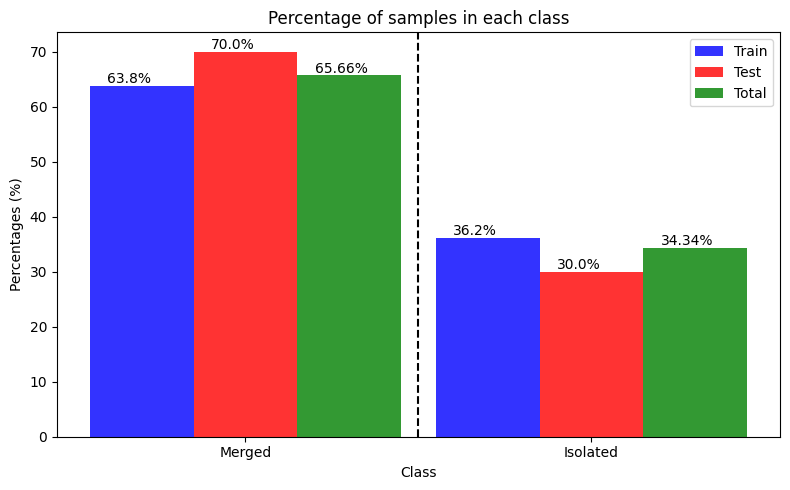

<Figure size 640x480 with 0 Axes>

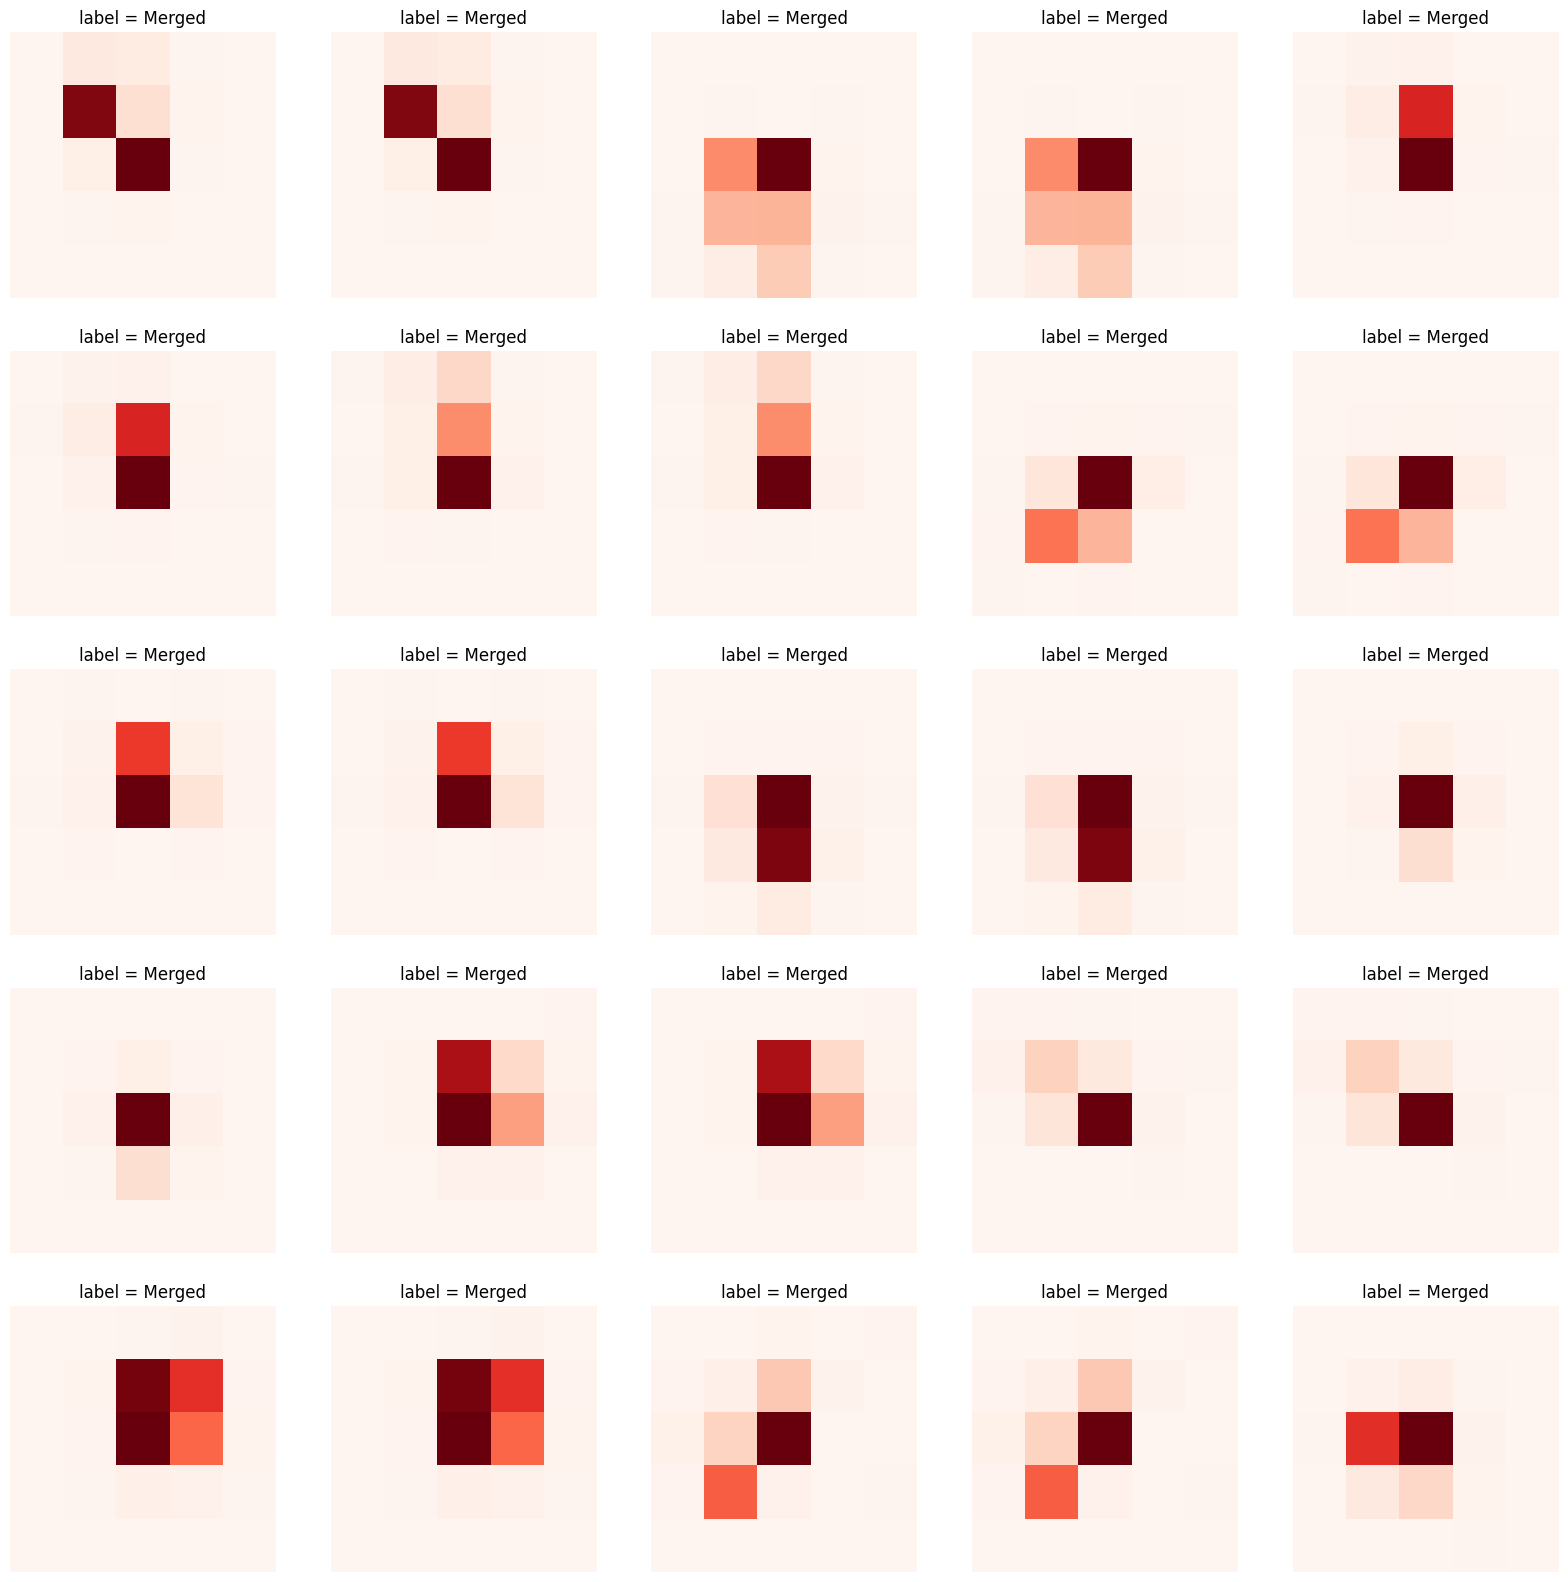

<Figure size 640x480 with 0 Axes>

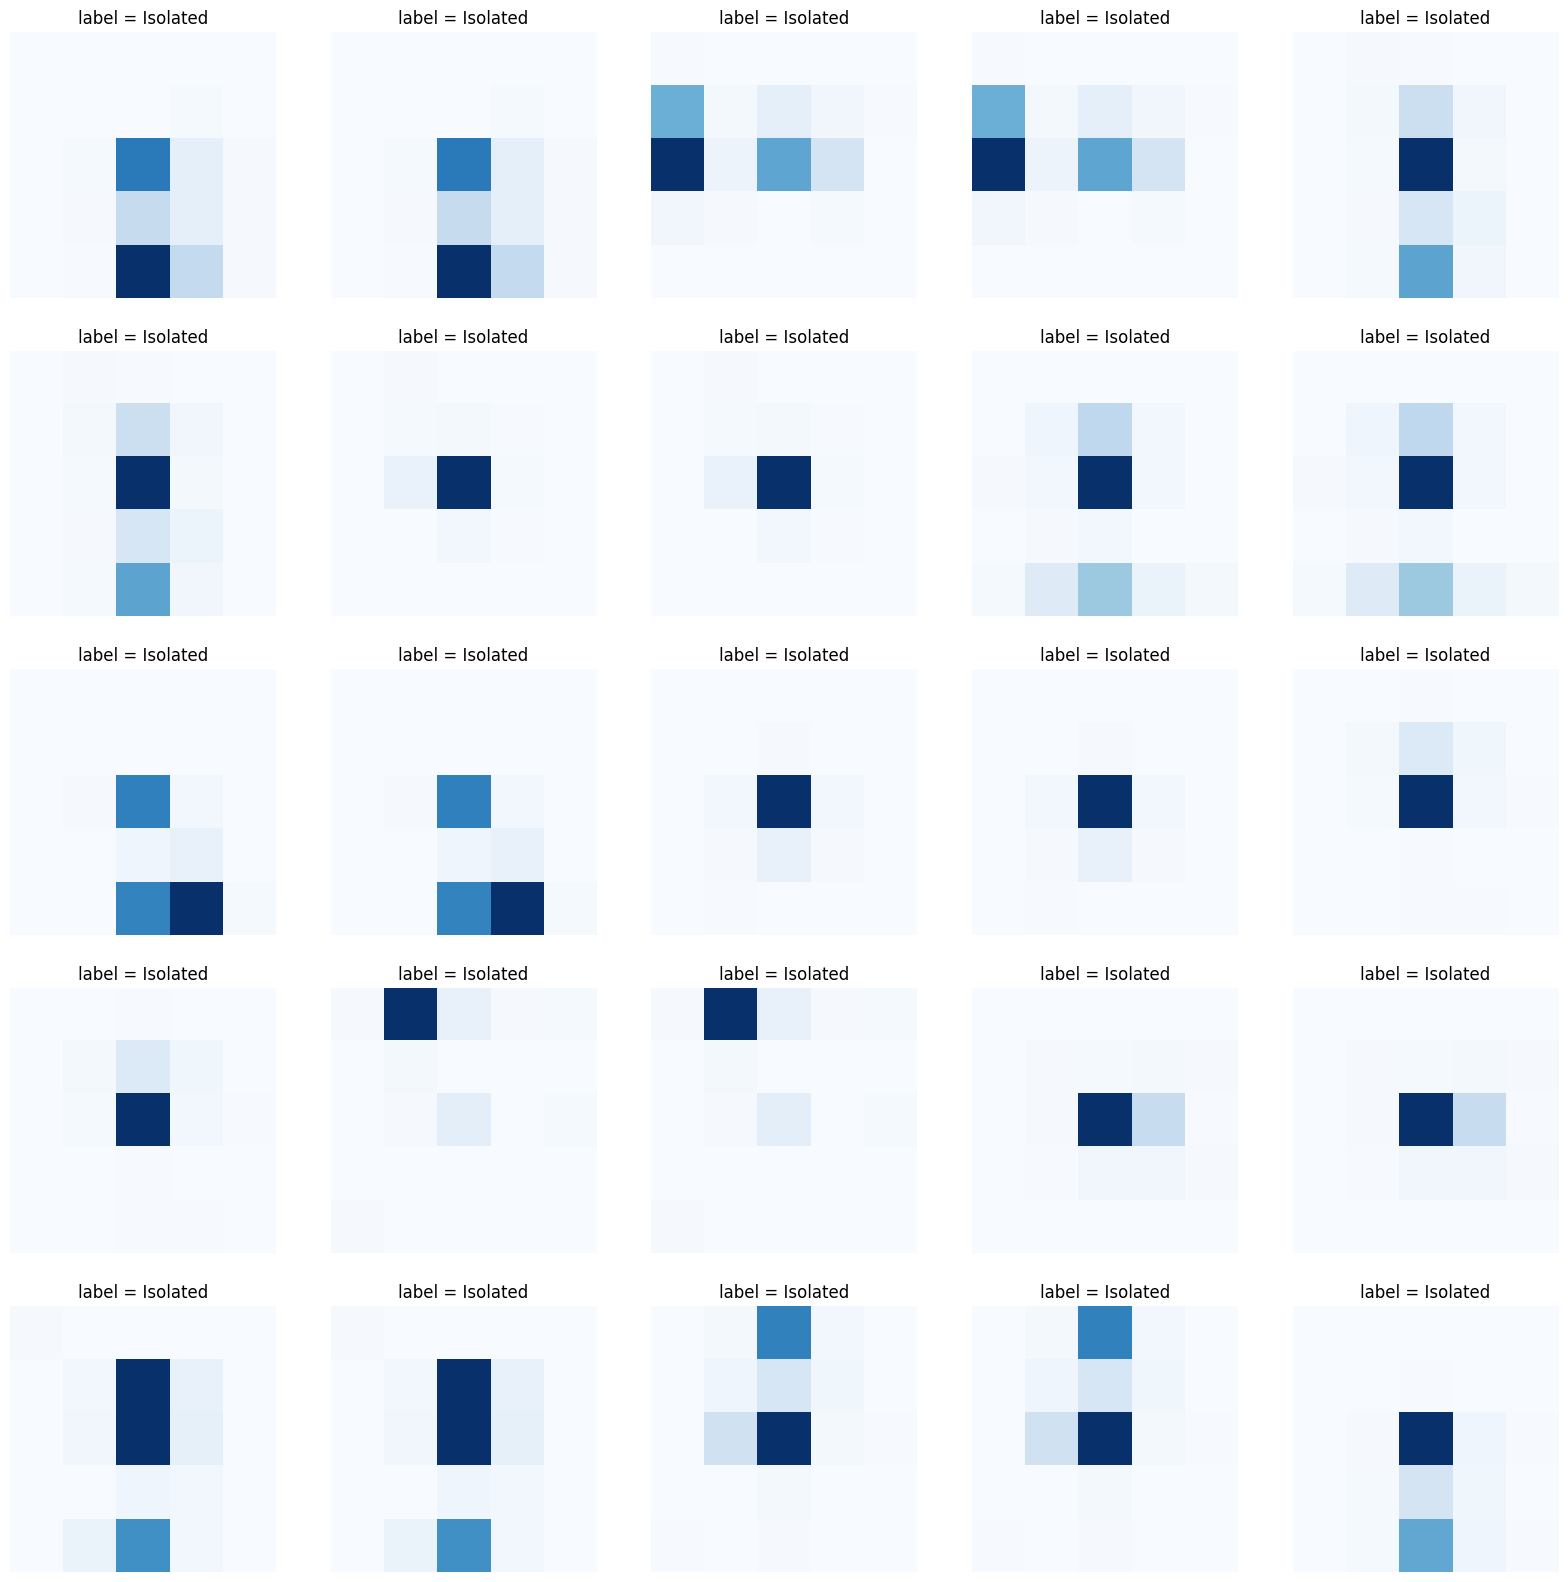

<Figure size 640x480 with 0 Axes>

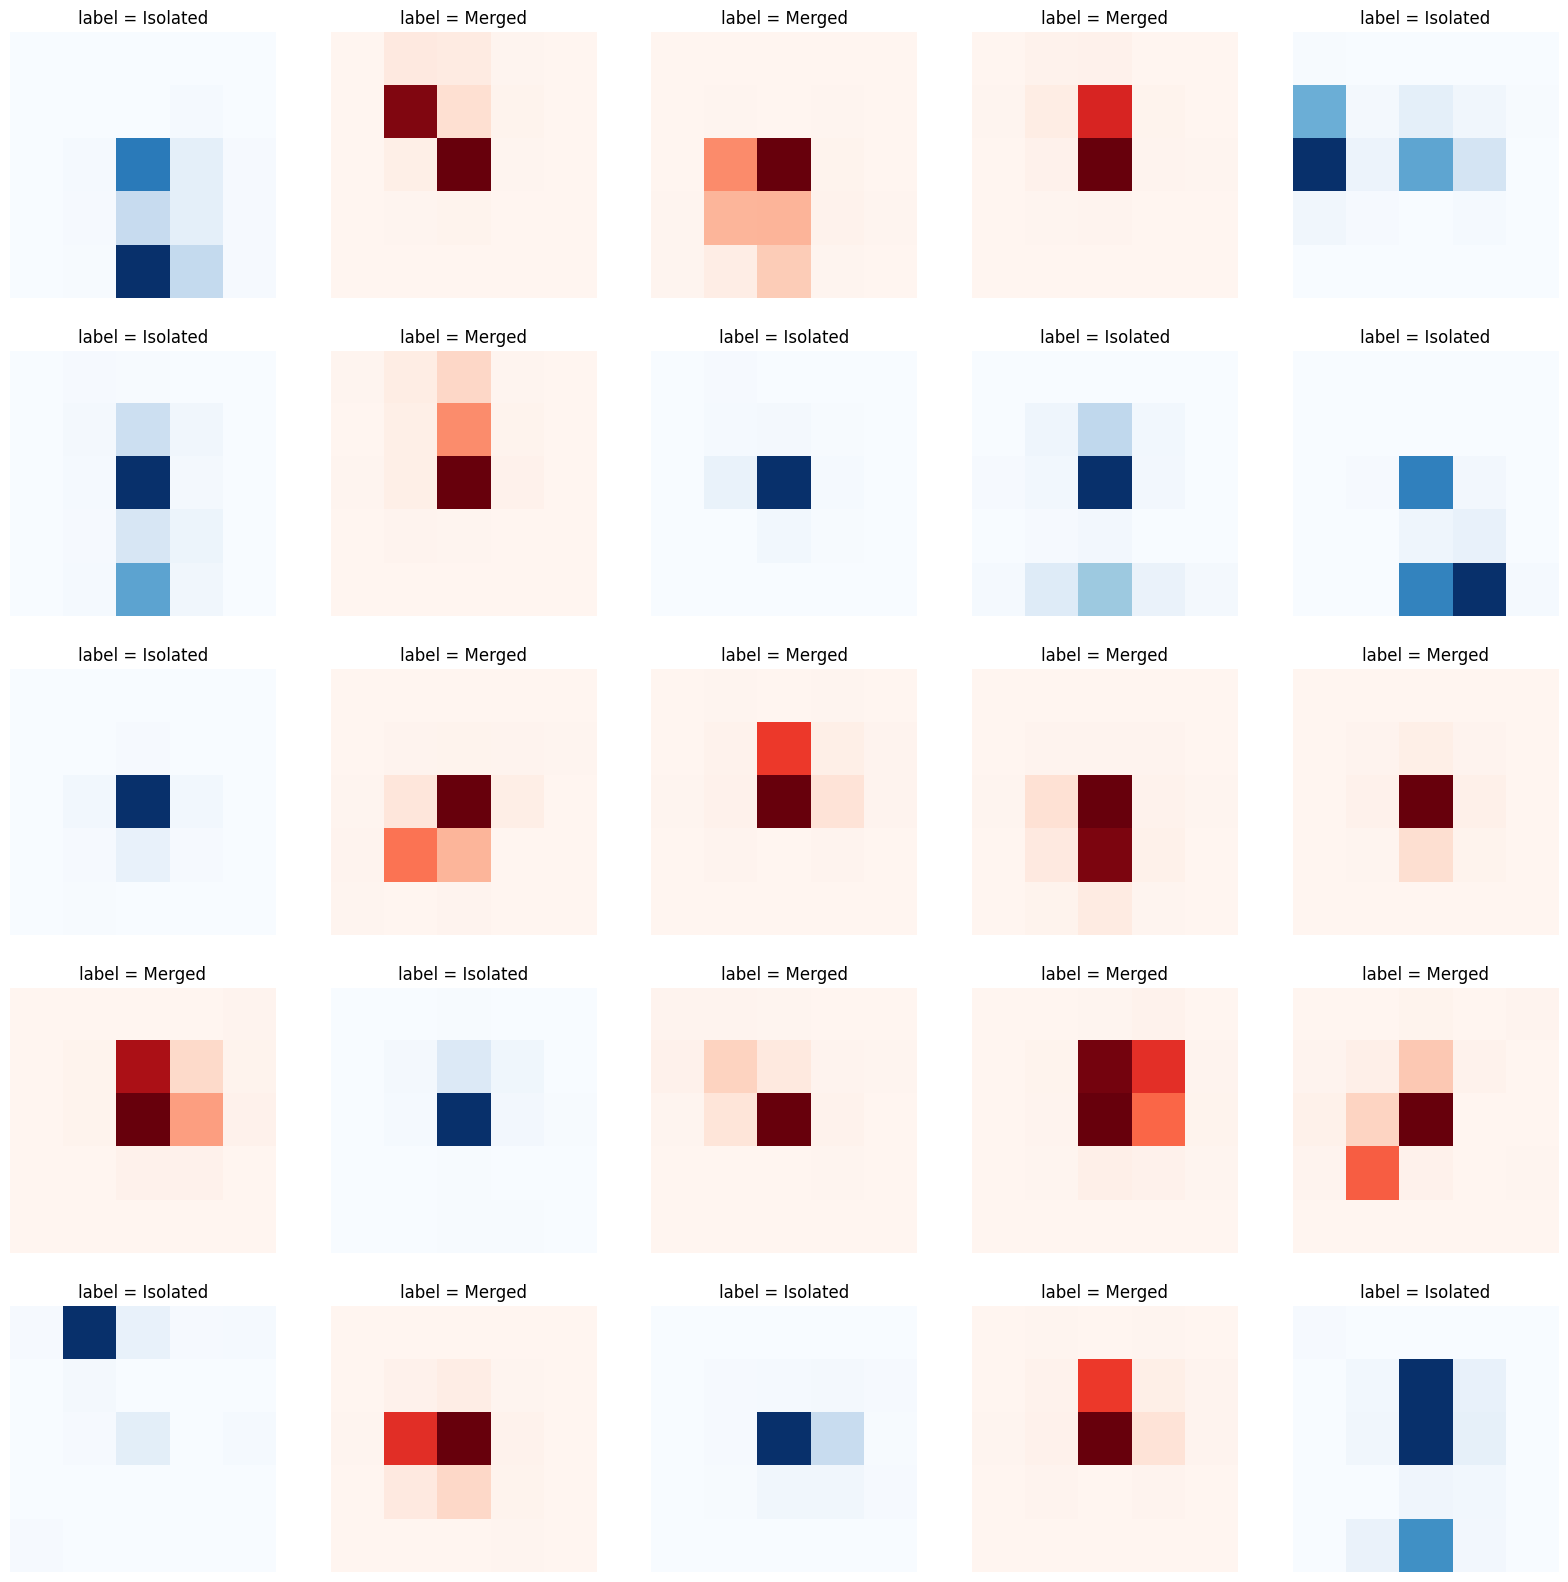

<Figure size 640x480 with 0 Axes>

Epoch 1/100
28/28 [==============================] - 1s 13ms/step - loss: 2.9050 - accuracy: 0.3430 - val_loss: 1.1005 - val_accuracy: 0.3750
Epoch 2/100
28/28 [==============================] - 0s 6ms/step - loss: 1.0182 - accuracy: 0.5448 - val_loss: 0.9960 - val_accuracy: 0.5536
Epoch 3/100
28/28 [==============================] - 0s 5ms/step - loss: 0.8553 - accuracy: 0.5179 - val_loss: 0.8692 - val_accuracy: 0.5268
Epoch 4/100
28/28 [==============================] - 0s 6ms/step - loss: 0.7554 - accuracy: 0.5538 - val_loss: 0.7838 - val_accuracy: 0.5714
Epoch 5/100
28/28 [==============================] - 0s 5ms/step - loss: 0.6682 - accuracy: 0.6143 - val_loss: 0.7130 - val_accuracy: 0.6161
Epoch 6/100
28/28 [==============================] - 0s 5ms/step - loss: 0.5944 - accuracy: 0.6906 - val_loss: 0.6461 - val_accuracy: 0.6607
Epoch 7/100
28/28 [==============================] - 0s 5ms/step - loss: 0.5358 - accuracy: 0.7399 - val_loss: 0.5945 - val_accuracy: 0.6696
Epoch 8/100


/home/johnm100/miniconda3/envs/myenv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


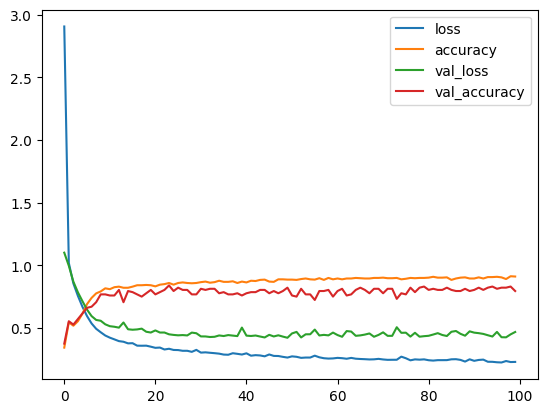

8/8 [==============================] - 0s 3ms/step


<Figure size 640x480 with 0 Axes>

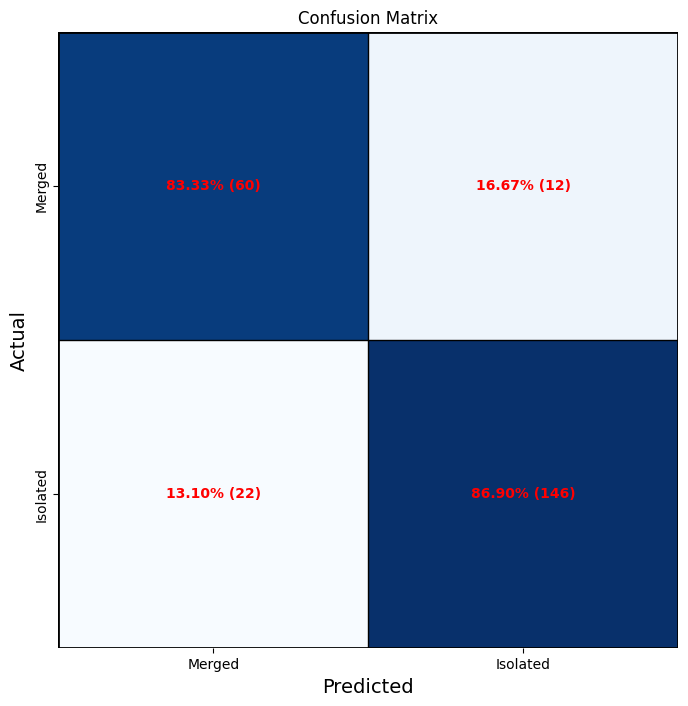

8/8 [==============================] - 0s 4ms/step


<Figure size 640x480 with 0 Axes>

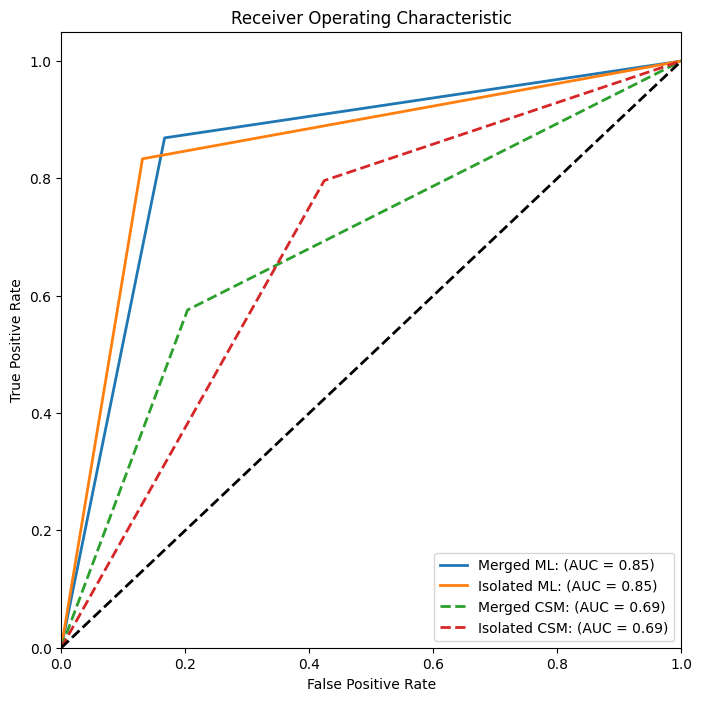

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 5, 5, 1)]            0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 4, 4, 32)             160       ['image_input[0][0]']         
                                                                                                  
 conv2 (Conv2D)              (None, 3, 3, 9)              1161      ['conv1[0][0]']               
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 1, 1, 9)              0         ['conv2[0][0]']               
 g2D)                                                                                         

In [8]:
test_size = 0.3 # train test split size
augment_images = False # augment images
model_name = 'johns_model' # model name
df = DataUtils.load_data_frame() # load data frame

train, test = load_data(df = df, test_size = 0.3, augment_images = False) # load data

# # convert to np arrays
x_train_img, x_train_fea, y_train_lab, y_train_lab_str = convert_to_np_array(train)
x_test_img, x_test_fea, y_test_lab, y_test_lab_str = convert_to_np_array(test)


# plot percentage histogram
plot_combined_percentage_histogram(y_train_lab, y_test_lab, class_dict, f'plots/percentage_histogram.png')

# plot samples
plot_samples(x_train_img, y_train_lab, class_dict, f'plots/merged_samples.png', do_max_loc=False, target='Merged')
plot_samples(x_train_img, y_train_lab, class_dict, f'plots/isolated_samples.png', do_max_loc=False, target='Isolated')
plot_samples(x_train_img, y_train_lab, class_dict, f'plots/samples.png', do_max_loc=False, target=None)


# train model
model, history = train_model(x_train_img, x_train_fea, y_train_lab, epochs=100, batch_size=16, validation_split=0.2)

# save model
model.save(f'models/{model_name}.h5') # you can load the model using keras.models.load_model('model.h5')

# plot history
plot_training_history(history, f'plots/{model_name}_training_history.png')

# plot confusion matrix
plot_confusion_matrix([x_test_img, x_test_fea], y_test_lab, model, class_dict, f'plots/{model_name}_confusion_matrix.png')

#Get old predictions 
_ , test_old = load_data(df = df, test_size = .99, augment_images = False) # load data

# # convert to np arrays
pred_old, truth_y = convert_to_np_array_get_old_pred(test_old)

# plot roc curve
#plot_roc_curve([x_test_img, x_test_fea], y_test_lab, model, class_dict, f'plots/{model_name}_roc_curve.png')

plot_roc_curve_all(x_test_old=pred_old, 
                y_test_old=truth_y, 
                model=model, 
                x_test_ml=[x_test_img, x_test_fea], 
                y_test_ml=y_test_lab, 
                class_dict=class_dict, 
                threshold=0.2)

# print model summary
model.summary()

# plot model architecture
# plot_model_architecture(model, f'plots/{model_name}_model_architecture.png')


In [9]:
_ , test_old = load_data(df = df, test_size = .99, augment_images = False) # load data

# # convert to np arrays
pred_old, truth_y = convert_to_np_array_get_old_pred(test_old)

In [10]:
print(pred_old,truth_y)

[[3.6060e-01]
 [6.2242e-01]
 [6.4648e-01]
 [4.5020e-01]
 [2.8660e-02]
 [6.2496e-01]
 [6.9664e-01]
 [3.8254e-01]
 [3.8756e-01]
 [9.8537e-01]
 [0.0000e+00]
 [5.3550e-02]
 [0.0000e+00]
 [1.3883e-01]
 [9.2266e-01]
 [5.7516e-01]
 [6.6181e-01]
 [1.3550e-02]
 [4.5188e-01]
 [2.0354e-01]
 [4.5156e-01]
 [0.0000e+00]
 [0.0000e+00]
 [0.0000e+00]
 [5.3102e-01]
 [0.0000e+00]
 [0.0000e+00]
 [1.0396e-01]
 [7.4000e-04]
 [0.0000e+00]
 [9.2988e-01]
 [8.4205e-01]
 [0.0000e+00]
 [8.6278e-01]
 [2.7000e-04]
 [3.8800e-03]
 [3.9700e-03]
 [2.5770e-02]
 [0.0000e+00]
 [7.8902e-01]
 [1.1370e-02]
 [5.5043e-01]
 [0.0000e+00]
 [0.0000e+00]
 [3.8214e-01]
 [5.4686e-01]
 [0.0000e+00]
 [3.0427e-01]
 [2.0354e-01]
 [2.5400e-02]
 [8.4205e-01]
 [3.0000e-05]
 [9.0612e-01]
 [3.7881e-01]
 [0.0000e+00]
 [5.7271e-01]
 [4.9544e-01]
 [7.4515e-01]
 [9.7960e-02]
 [9.3133e-01]
 [0.0000e+00]
 [2.8660e-02]
 [1.0160e-02]
 [3.8800e-03]
 [7.4509e-01]
 [9.6299e-01]
 [6.3649e-01]
 [3.2811e-01]
 [6.6670e-01]
 [9.9778e-01]
 [5.5400e-03]
 [6.96

In [11]:
old_truth_state = convert_class_vector_to_string(truth_y, class_dict)

In [13]:
def plot_roc_curve_old(x_test, y_test, class_dict, threshold=.5, filename = None):
    pred = convert_predictions_to_class_vector_old(x_test,class_dict,threshold)
    pred_state = convert_class_vector_to_string(pred, class_dict)
    true_state = convert_class_vector_to_string(y_test, class_dict)
    
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(class_dict)):
        fpr[i], tpr[i], _ = roc_curve(true_state == list(class_dict.keys())[i], pred_state == list(class_dict.keys())[i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 8))
    lw = 2
    for i in range(len(class_dict)):
        plt.plot(fpr[i], tpr[i], lw=lw, label=f'{list(class_dict.keys())[i]} (AUC = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    if filename:
        plt.savefig(filename)       


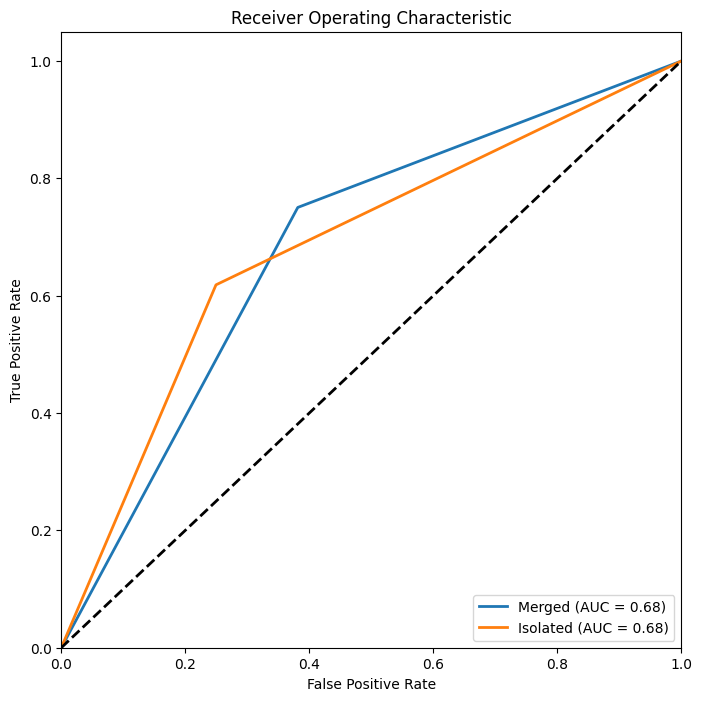

In [14]:
plot_roc_curve_old(pred_old,truth_y,class_dict,threshold=.5)

In [15]:
def plot_roc_curve_all(x_test_old, y_test_old, model, x_test_ml, y_test_ml, class_dict, threshold=0.5, filename=None):
    pred = model.predict(x_test_ml)
    pred_old = convert_predictions_to_class_vector_old(x_test_old,class_dict,threshold)
    
    pred_state = convert_class_vector_to_string(pred, class_dict)
    true_state = convert_class_vector_to_string(y_test_ml, class_dict)
    pred_state_old = convert_class_vector_to_string(pred_old, class_dict)
    true_state_old = convert_class_vector_to_string(y_test_old, class_dict)
    
    fpr = {}
    tpr = {}
    fpr_old = {}
    tpr_old = {}
    roc_auc = {}
    roc_auc_old = {}
    for i in range(len(class_dict)):
        fpr[i], tpr[i], _ = roc_curve(true_state == list(class_dict.keys())[i], pred_state == list(class_dict.keys())[i])
        fpr_old[i], tpr_old[i], _ = roc_curve(true_state_old == list(class_dict.keys())[i], pred_state_old == list(class_dict.keys())[i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        roc_auc_old[i] = auc(fpr_old[i], tpr_old[i])

    plt.figure(figsize=(8, 8))
    lw = 2
    for i in range(len(class_dict)):
        plt.plot(fpr[i], tpr[i], lw=lw, label=f'{list(class_dict.keys())[i]} ML: (AUC = {roc_auc[i]:0.2f})')
    for i in range(len(class_dict)):
        plt.plot(fpr_old[i], tpr_old[i], lw=lw, linestyle='--', label=f'{list(class_dict.keys())[i]} CSM: (AUC = {roc_auc_old[i]:0.2f})')

    plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    if filename:
        plt.savefig(filename)  